# Physics-informed neural network (PINN) demo


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import qmc

## Initial setup

First, we define a few helper functions.

In [3]:
class FCN(nn.Module):
    def __init__(self, input_size, output_size, num_hidden_units, num_hidden_layers):
        super(FCN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.append(nn.Linear(input_size, num_hidden_units))
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(nn.Linear(num_hidden_units, num_hidden_units))
        self.output_layer = nn.Linear(num_hidden_units, output_size)

    def forward(self, x, y):
        out = torch.cat((x, y), dim=1)
        for layer in self.hidden_layers:
            out = torch.tanh(layer(out))
        out = self.output_layer(out)
        return out

# Define a custom loss function to compute physics loss
def physics_loss(output, X, Y):
    # Compute gradients along X and Y separately
    grad_X = torch.autograd.grad(output, X, torch.ones_like(output), create_graph=True)[0]
    grad_Y = torch.autograd.grad(output, Y, torch.ones_like(output), create_graph=True)[0]

    # Compute second derivatives
    grad_X_X = torch.autograd.grad(grad_X, X, torch.ones_like(grad_X), create_graph=True)[0]
    grad_Y_Y = torch.autograd.grad(grad_Y, Y, torch.ones_like(grad_Y), create_graph=True)[0]

    # Compute Laplacian
    laplacian = grad_X_X + grad_Y_Y

    # Compute physics loss
    loss = torch.mean(laplacian ** 2)

    return loss

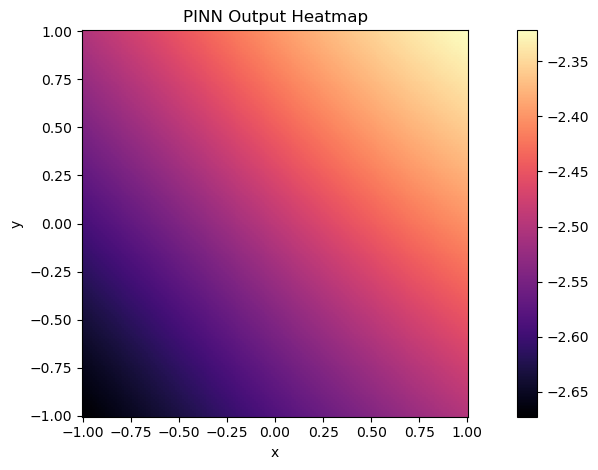

Loss: 1.564982533454895
BC Loss: 1.5639536380767822
PDE Loss: 1.2150331087923406e-07


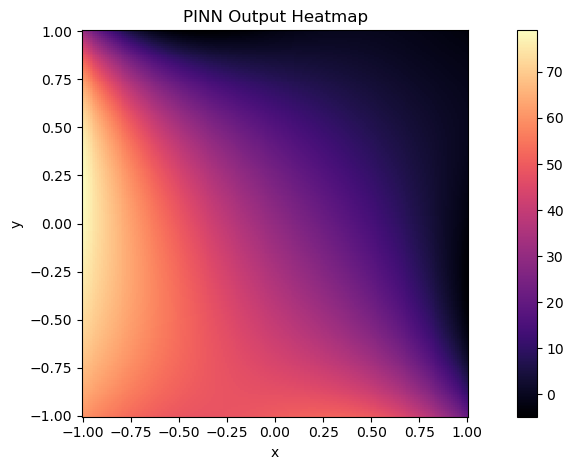

Loss: 0.05695435032248497
BC Loss: 0.04705710709095001
PDE Loss: 0.0034477461129426954


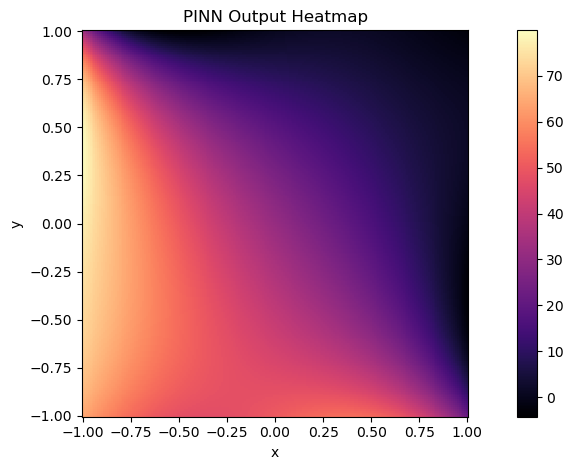

Loss: 0.04636838659644127
BC Loss: 0.03767542541027069
PDE Loss: 0.002721655089408159


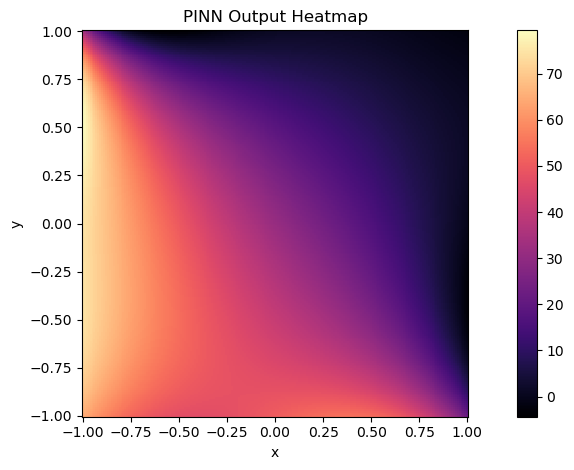

Loss: 0.04056153818964958
BC Loss: 0.03293624520301819
PDE Loss: 0.002247897069901228


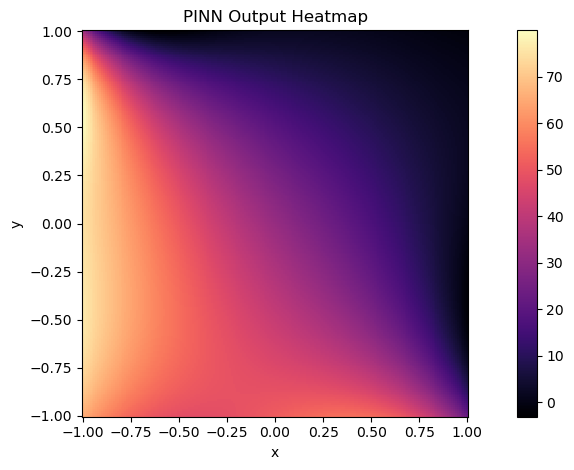

Loss: 0.03877975791692734
BC Loss: 0.031514424830675125
PDE Loss: 0.0018713955301791429


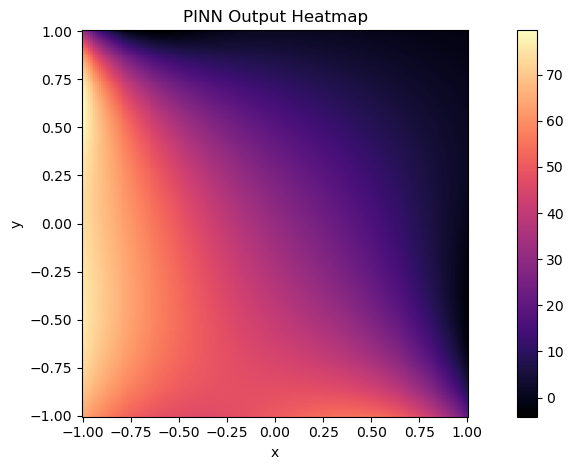

Loss: 0.03598475828766823
BC Loss: 0.029466284438967705
PDE Loss: 0.0019526976160705088


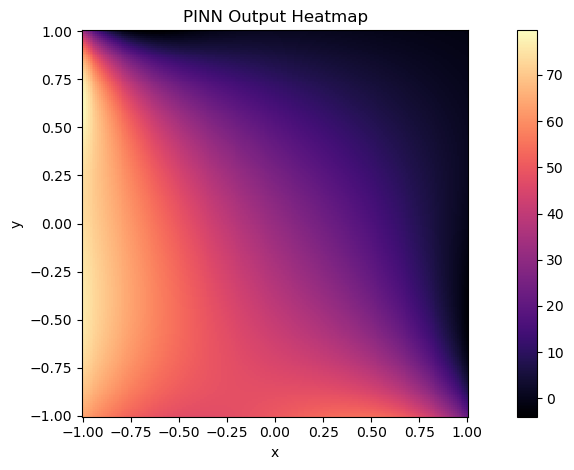

Loss: 0.03405865281820297
BC Loss: 0.027938099578022957
PDE Loss: 0.0017945155967026948


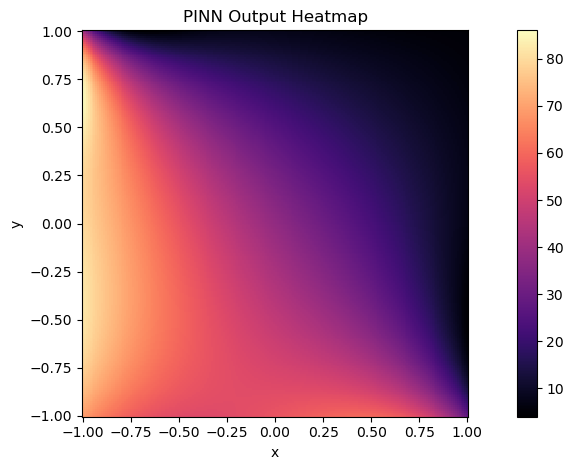

Loss: 0.06950768828392029
BC Loss: 0.05275508761405945
PDE Loss: 0.002481953054666519


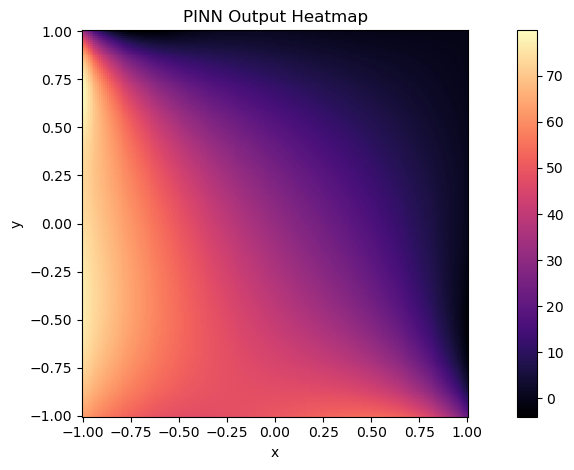

Loss: 0.029491079971194267
BC Loss: 0.024409232661128044
PDE Loss: 0.0013747236225754023


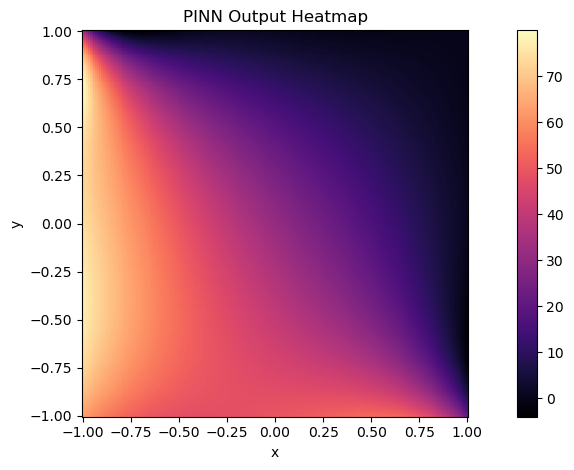

Loss: 0.027124598622322083
BC Loss: 0.02236703410744667
PDE Loss: 0.0013975496403872967


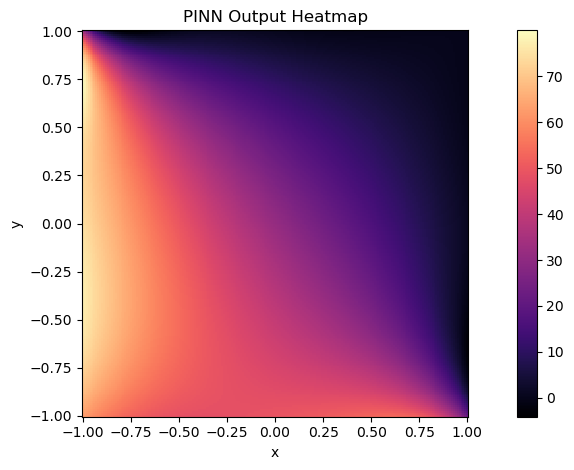

Loss: 0.024702375754714012
BC Loss: 0.020339326933026314
PDE Loss: 0.0013148910831660033


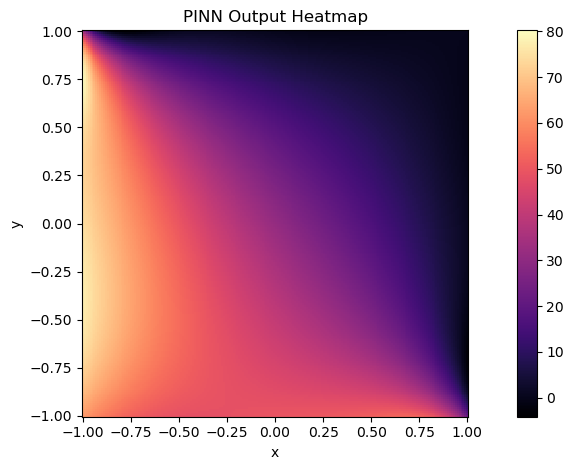

Loss: 0.022075511515140533
BC Loss: 0.01833127811551094
PDE Loss: 0.0010591813595965504


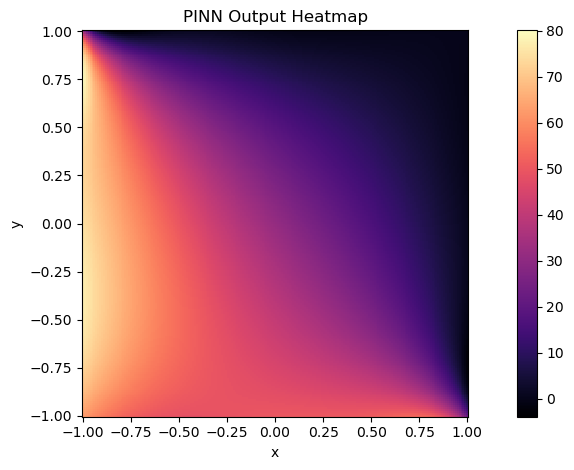

Loss: 0.019724823534488678
BC Loss: 0.01635713502764702
PDE Loss: 0.0010318689979612826


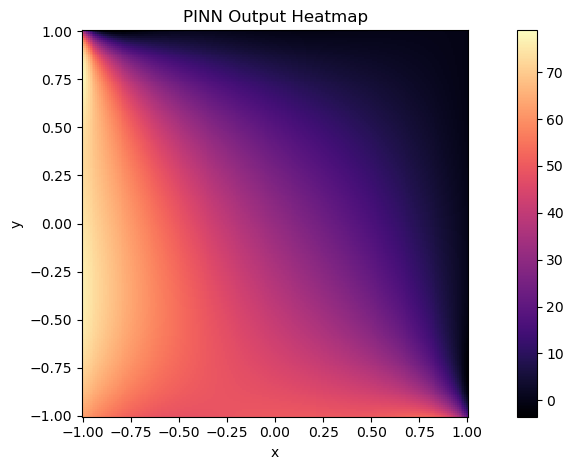

Loss: 0.01711525209248066
BC Loss: 0.014369691722095013
PDE Loss: 0.0009166853735223412


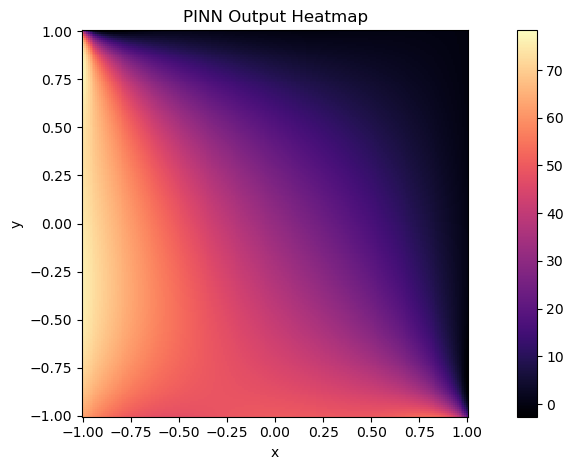

Loss: 0.014105239883065224
BC Loss: 0.011502377688884735
PDE Loss: 0.001114232512190938


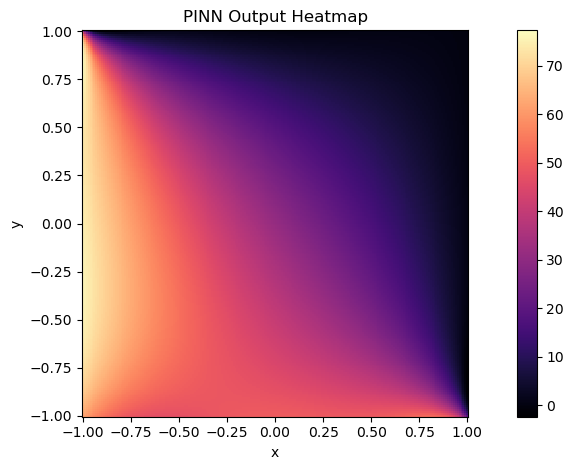

Loss: 0.01335106696933508
BC Loss: 0.010506555438041687
PDE Loss: 0.0015778164379298687


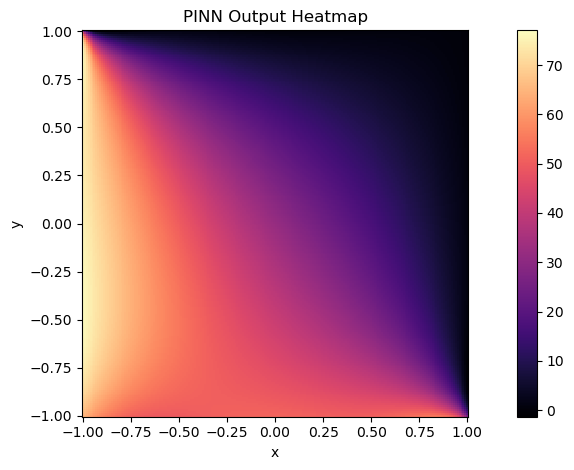

Loss: 0.016520636156201363
BC Loss: 0.009865176863968372
PDE Loss: 0.0050440382212400435


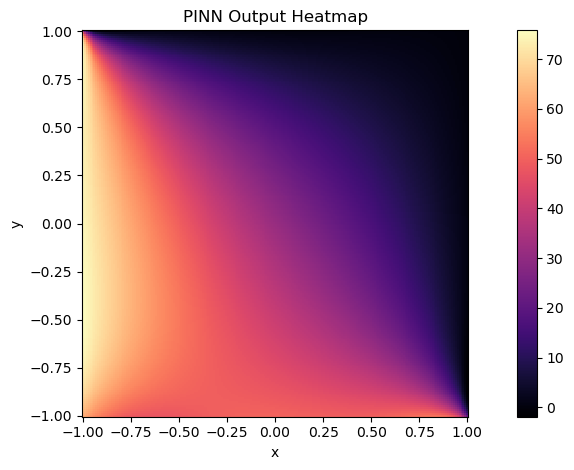

Loss: 0.011174682527780533
BC Loss: 0.009106414392590523
PDE Loss: 0.0007592053385451436


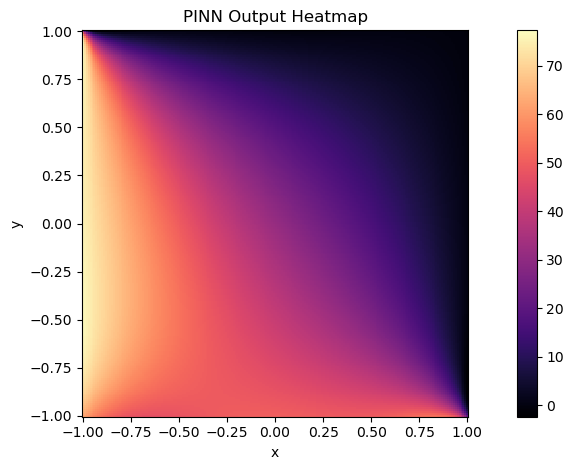

Loss: 0.010324190370738506
BC Loss: 0.008388858288526535
PDE Loss: 0.0007527071982622146


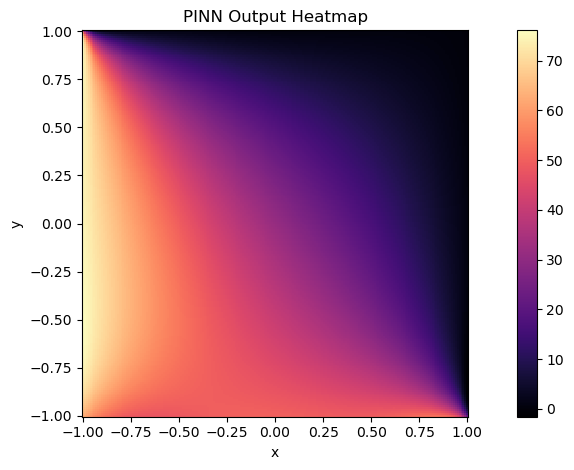

Loss: 0.01469687931239605
BC Loss: 0.00871000625193119
PDE Loss: 0.004062690027058125


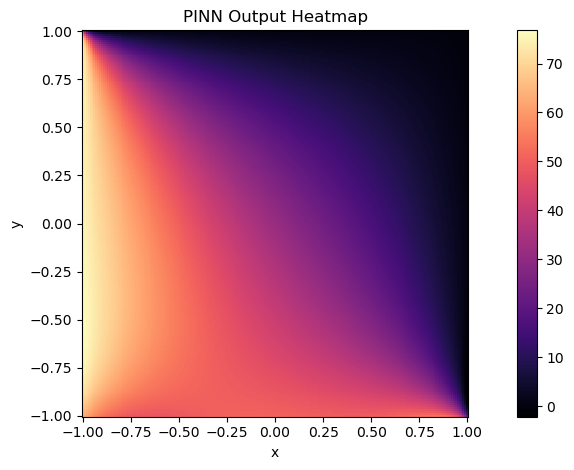

Loss: 0.00982554443180561
BC Loss: 0.008128661662340164
PDE Loss: 0.0005997799336910247


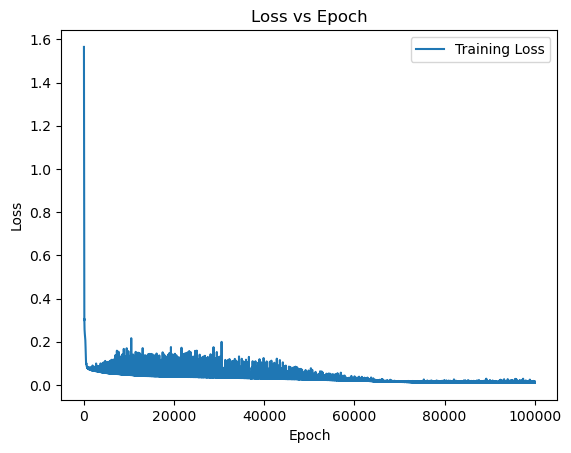

In [15]:
# define a neural network to train
pinn = FCN(2,1,64,9)

# define boundary points, for the boundary loss
bc = torch.linspace(-1,1,200).view(-1,1).requires_grad_(True)# (200, 1)
ones = torch.ones((200,1))

# define training points over the entire domain, for the physics loss
x_physics = torch.linspace(-1,1,200).view(-1,1).requires_grad_(True)# (200, 1)
y_physics = torch.linspace(-1,1,200).view(-1,1).requires_grad_(True)# (200, 1)
X, Y = torch.meshgrid(x_physics.squeeze(), y_physics.squeeze())


optimiser = torch.optim.Adam(pinn.parameters(),lr=1e-4)
num_epochs = 100000
losses = []
for i in range(num_epochs+1):
    optimiser.zero_grad()

    # compute each term of the PINN loss function above
    # using the following hyperparameters
    lambda1 = 0.3

    # compute boundary loss 1
    T = pinn(-1*ones ,bc)# (200, 1)
    loss1 = torch.mean((torch.squeeze(T) - 1)**2)

    # compute boundary loss 2
    T = pinn(1*ones ,bc)# (200, 1)
    loss2 = torch.mean((torch.squeeze(T) - 0)**2)

    # compute boundary loss 3
    T = pinn(bc,-1*ones )# (200, 1)
    loss3 = torch.mean((torch.squeeze(T) - 2/3)**2)

    # compute boundary loss 4
    T = pinn(bc,1*ones)# (200, 1)
    loss4 = torch.mean((torch.squeeze(T) - 0)**2)

    # compute physics loss
    T = pinn(X.reshape(-1, 1), Y.reshape(-1, 1)).reshape(200, 200)
    loss5 = physics_loss(T, X, Y)

    # backpropagate joint loss, take optimiser step
    loss = loss1 + 1.5 * loss2 + loss3 + 1.5 * loss4 + lambda1 * loss5
    bc_loss= loss1 + loss2 + loss3 + loss4
    loss.backward()
    optimiser.step()
    losses.append(loss.item())

    # plot the result as training progresses
    if i % 5000 == 0:
        #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        plt.figure()
        x_1 = X.detach().numpy()
        y_1 = Y.detach().numpy()
        plt.pcolormesh(x_1, y_1, 75.* T.detach().numpy(), cmap="magma")  # Assuming T is the output of the PINN
        plt.colorbar()
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("PINN Output Heatmap")
        plt.tight_layout()
        plt.axis("square")
        plt.show()
        print("Loss:", loss.item())
        print("BC Loss:", bc_loss.item())
        print("PDE Loss:", lambda1*loss5.item())


plt.plot(range(1, num_epochs+2), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [16]:
T=75.*T

In [5]:
n = 200
l = 1.
r = 2*l/(n+1)
T1 = np.zeros([n*n, n*n])

bc = {
    "x=-l": 75.,
    "x=+l": 0.,
    "y=-l": 50.,
    "y=+l": 0.
}

In [6]:
B = np.zeros([n, n])
k = 0
for i in range(n):
    x = i * r
    for j in range(n):
        y = j * r
        M = np.zeros([n, n])
        M[i, j] = -4
        if i != 0: # ok i know
            M[i-1, j] = 1
        else:
            B[i, j] += -bc["y=-l"]   # b.c y = 0
        if i != n-1:
            M[i+1, j] = 1
        else:
            B[i, j] += -bc["y=+l"]   # b.c y = l
        if j != 0:
            M[i, j-1] = 1
        else:
            B[i, j] += -bc["x=-l"]   # b.c x = 0
        if j != n-1:
            M[i, j+1] = 1
        else:
            B[i, j] += -bc["x=+l"]   # b.c x = l
        #B[i, j] += -r**2 * q(x, y) * K(x, y)
        m = np.reshape(M, (1, n**2))
        T1[k, :] = m
        k += 1

#
b = np.reshape(B, (n**2, 1))
start = time.time()
T1 = np.matmul(np.linalg.inv(T1), b)
T1 = T1.reshape([n, n])
Temperature = T1
end = time.time()
T2 = torch.tensor(T1)

In [4]:
### plotting
plt.figure("", figsize=(12, 6))
#
X1 = torch.linspace(-1, +1, n)
Y1 = torch.linspace(-1, +1, n)
X0, Y0 = torch.meshgrid(X1, Y1)
X1 = X0.reshape([n*n, 1])
Y1 = Y0.reshape([n*n, 1])
#
plt.subplot(221)
plt.pcolormesh(X0, Y0, T.detach().numpy(), cmap="magma")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("PINN")
plt.tight_layout()
plt.axis("square")
#
x = np.linspace(-1, +1, n)
y = np.linspace(-1, +1, n)
x, y = np.meshgrid(x, y)
#
plt.subplot(222)
plt.pcolormesh(x, y, T2, cmap="magma")
plt.colorbar()
plt.title(r"FDM")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-1, +1)
plt.ylim(-1, +1)
plt.tight_layout()
plt.axis("square")
plt.savefig("heat01.png")
#


NameError: name 'n' is not defined

<Figure size 1200x600 with 0 Axes>

In [24]:
T2 = torch.tensor(T1)

diff = (torch.abs(T2-T)/torch.abs(T2))*100
error = torch.mean(diff)
print(f"Avg Percentage Error is:", error.item())

Avg Percentage Error is: 24.109531156876457
